DATASET PREPARATION TO BOUNDARY LAYER CLASSIFICATION
=================
Prepare dataset from ceilometer and radiometer data in order to apply boundary layer classification.
The point of this preparation is to interpolate the atmospheric variables onto a common grid and save it in a ready-to-use format for classification algorithms.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import time


from blcovid import utils
from blcovid import graphics
from blcovid import prepdataset

Settings
=======

Parameters of the interpolation
--------------------------------

In [2]:
z_max=2000						# Maximum altitude (m agl)
predictors = ['BT','T']			# Variables to put in the dataset (['BT','T'] or ['BT','T','Z'])
dt_common = 30			# Time resolution common grid
dz_common = 40			# Vertical resolution common grid
interpMethod = 'linear'			# Interpolation method ('linear','cubic','nearestneighbors')

Outputs
---------

In [3]:
outputDir="../working-directories/1-unlabelled-datasets/"
saveNetcdf=False

Inputs
-------

In [4]:
day=dt.datetime(2015,2,19)
CEI_file = "../working-directories/0-original-data/CEILOMETER/PASSY_PASSY_CNRM_CEILOMETER_CT25K_2015_0219_V01.nc"
MWR_file = "../working-directories/0-original-data/MWR/PASSY2015_SALLANCHES_CNRM_MWR_HATPRO_2015_0219_V01.nc"

Extraction
===========

Raw data
---------

In [5]:
t_cei,z_cei,backscatter=utils.extractOrigData(CEI_file,altmax=z_max)
# NB: here the backscatter signal is raw, it is NOT in decibel.

# Negative backscatter are outliers + conversion to decibel
with np.errstate(invalid='ignore'):
    backscatter[backscatter<=0]=np.nan
    backscatter=10*np.log10(backscatter)

print('\n--- CEILOMETER ---')
print("Size=",np.size(backscatter))
print("Percentage of NaN=",100*np.sum(np.isnan(backscatter))/np.size(backscatter),"%")
with np.errstate(invalid='ignore'):
    print("Percentage of negative values=",100*np.sum(backscatter<0)/np.size(backscatter),"%")
print("VALUES : min=",np.nanmin(backscatter),"max=",np.nanmax(backscatter),"mean=",np.nanmean(backscatter),"median=",np.nanmedian(backscatter))
print("GRID : dt=",np.mean(np.diff(t_cei)),"dz=",np.mean(np.diff(z_cei)),"Nt=",len(t_cei),"Nz=",len(z_cei),"data shape=",np.shape(backscatter))
print('------')


--- CEILOMETER ---
Size= 766080
Percentage of NaN= 16.959455931495405 %
Percentage of negative values= 31.80372807017544 %
VALUES : min= -10.0 max= 25.154366 mean= 1.3808296 median= 1.105897
GRID : dt= 0:00:14.999305 dz= 15.0 Nt= 5760 Nz= 133 data shape= (5760, 133)
------


In [6]:
t_mwr,z_mwr,temperature=utils.extractOrigData(MWR_file,altmax=z_max)

print('\n--- RADIOMETER ---')
print("Size=",np.size(temperature))
print("Percentage of NaN=",100*np.sum(np.isnan(temperature))/np.size(temperature),"%")
print("VALUES : min=",np.nanmin(temperature),"max=",np.nanmax(temperature),"mean=",np.nanmean(temperature),"median=",np.nanmedian(temperature))
print("GRID : dt=",np.mean(np.diff(t_mwr)),"dz=",np.mean(np.diff(z_mwr)),"Nt=",len(t_mwr),"Nz=",len(z_mwr),"data shape=",np.shape(temperature))
print('------')


--- RADIOMETER ---
Size= 2185
Percentage of NaN= 0.0 %
VALUES : min= 270.45056 max= 283.17554 mean= 275.56207 median= 275.094
GRID : dt= 0:12:33.464912 dz= 97.22222 Nt= 115 Nz= 19 data shape= (115, 19)
------


In [7]:
# Check boundaries
print("MWR starts at:",t_mwr[0],'ends at',t_mwr[-1])
print("CEI starts at:",t_cei[0],'ends at',t_cei[-1])

MWR starts at: 2015-02-19 00:05:45 ends at 2015-02-19 23:57:20
CEI starts at: 2015-02-19 00:00:12 ends at 2015-02-19 23:59:53


Quicklooks
-----------

Text(0, 0.5, 'Alt (m agl)')

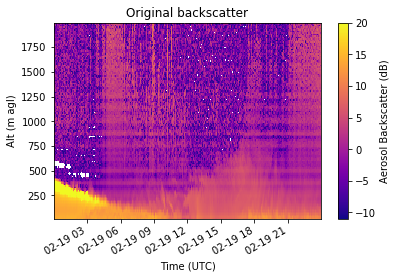

In [8]:
plt.figure()
plt.title("Original backscatter")
with np.errstate(divide='ignore',invalid='ignore'):
    plt.pcolormesh(t_cei,z_cei,backscatter.T,vmin=-11,vmax=20,cmap='plasma')
plt.colorbar(label="Aerosol Backscatter (dB)")
plt.gcf().autofmt_xdate()
plt.xlabel("Time (UTC)")
plt.ylabel("Alt (m agl)")

Text(0, 0.5, 'Alt (m agl)')

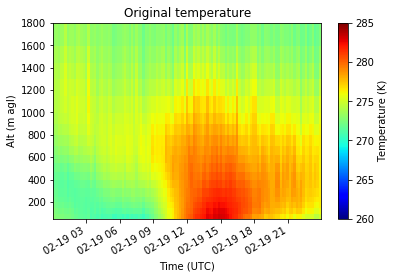

In [9]:
plt.figure()
plt.title("Original temperature")
plt.pcolormesh(t_mwr,z_mwr,temperature.T,vmin=260,vmax=285,cmap='jet')
plt.colorbar(label="Temperature (K)")
plt.gcf().autofmt_xdate()
plt.xlabel("Time (UTC)")
plt.ylabel("Alt (m agl)")

Interpolation
==============


Arrival grid
-------------

In [10]:
if dz_common=='MWR':
    # Alternative to creat a grid: take an existing one
    z_common,t_common=z_mwr,t_mwr
else:
    t_min=dt.datetime(2015,2,19)
    t_max=dt.datetime(2015,2,20)
    z_common,t_common=prepdataset.generategrid(t_min,t_max,z_max,dz_common,dt_common)

In [11]:
print("\nMWR | Invalid values after interpolation:")
if dz_common=='MWR' and np.sum(np.isnan(temperature[:,1:]))==0:
    T_query=temperature
else:
    T_query=prepdataset.estimateongrid(z_common,t_common,z_mwr,t_mwr,temperature,method=interpMethod)


print(" - T_query - #NaN=",np.sum(np.isnan(T_query)),"#Inf=",np.sum(np.isinf(T_query)),"#Neg=",np.sum(T_query<=0))


MWR | Invalid values after interpolation:
 - T_query - #NaN= 288 #Inf= 0 #Neg= 0


/home/bouliech/anaconda3/envs/bl-classif/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less_equal
  


Detailed interpolation
--------------------------------

### Function argument docstring

In [12]:
# estimateongrid(z_target,t_target,z_known,t_known,V_known,method='linear'):
# '''Interpolate the data on a target grid knowning it on another grid.
# Grids are time-altitude.

# Supported interpolation methods: 'linear','cubic','nearestneighbors'

# For nearest neighbors, the number of neighbors must be passed as the
# first character. For example: method='nearestneighbors'
# For more insights about how to choose the good methods (error, computing time...)
# please refer to the notebook `tuto-0to1-prepdataset.ipynb`

# [IN]
    # - z_target (np.array[n1_z]): altitude vector of the target grid (m agl)
    # - t_target (list[n1_t] of datetime): time vector of the target grid
    # - z_known (np.array[n0_z]): altitude vector of the known grid (m agl)
    # - t_known (list[n0_t] of datetime): time vector of the known grid
    # - V_known (np.array[n0_t,n0_z]): data values on the known grid
    # - method (str): interpolation method
    
# [OUT]
    # - V_target (np.array[n1_t,n1_z]): valeurs sur la grilles cible'''
z_target=z_common
t_target=t_common
z_known =z_cei
t_known =t_cei
V_known =backscatter
method='linear'

### Preprocessing

#### Formatting

In [13]:
# Switch from format "data=f(coordinates)" to format "obs=f(predictors)"
st_known = utils.dtlist2slist(t_known)
st_target = utils.dtlist2slist(t_target)
X_known,Y_known=utils.grid_to_scatter(st_known,z_known,V_known)
X_target=utils.grid_to_scatter(st_target,z_target)

#### Remove missing values

In [14]:
# NaN are removed
X_known = X_known[~np.isnan(Y_known),:]
Y_known = Y_known[~np.isnan(Y_known)]

NB: Only methods that do not require normalisation are used here.
The problem of the normalisation here is that the backscatter must stay posititve.
Hence, normalisation (which would enable more accurate methods, like kriging) is postponed to a future release.

#### Cross-validation

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_known,Y_known,test_size=0.3, random_state=42)
print("Shape training set:",X_train.shape)
print("Shape testing set:",X_test.shape)
print("NaN checks:",np.isnan(X_train).sum(),np.isnan(X_test).sum(),np.isnan(y_train).sum(),np.isnan(y_test).sum())
print("Zero-or-negative checks:",(X_train<=0).sum(),(X_test<=0).sum(),(y_train<=0).sum(),(y_test<=0).sum())

Shape training set: (445309, 2)
Shape testing set: (190848, 2)
NaN checks: 0 0 0 0
Zero-or-negative checks: 51 35 172429 73743


### Actual interpolation
#### Estimation with 4-nearest neighbors

In [16]:
from sklearn.neighbors import KNeighborsRegressor
t0=time.time()      #::::::

KNN=KNeighborsRegressor(n_neighbors=4)

KNN.fit(X_train,y_train)
print("Score:",KNN.score(X_test,y_test))
t1=time.time()      #::::::
print("Time to fit+predict:",t1-t0,"(s)")

KNN.fit(X_known,Y_known)
Y_target = KNN.predict(X_target)
print("Nb of Nan or Inf:",np.isnan(Y_target).sum()+np.isinf(Y_target).sum())

Score: 0.8367986339026079
Time to fit+predict: 1.4427154064178467 (s)
Nb of Nan or Inf: 0


#### Estimation with cubic 2D interpolation

In [17]:
from scipy.interpolate import griddata
from sklearn.metrics import r2_score
t0=time.time()      #::::::

y_pred = griddata(X_train,y_train,X_test,method='cubic')
print("Score:",r2_score(y_test[~np.isnan(y_pred)],y_pred[~np.isnan(y_pred)]))
t1=time.time()      #::::::
print("Time to fit+predict:",t1-t0,"(s)")

Y_target = griddata(X_known,Y_known,X_target,method='cubic')
print("Nb of Nan or Inf:",np.isnan(Y_target).sum()+np.isinf(Y_target).sum())

Score: 0.7982341670914581
Time to fit+predict: 85.17694473266602 (s)
Nb of Nan or Inf: 48


#### Estimation with linear 2D interpolation

In [18]:
from scipy.interpolate import griddata
from sklearn.metrics import r2_score
t0=time.time()      #::::::

y_pred = griddata(X_train,y_train,X_test,method='linear')
print("Score:",r2_score(y_test[~np.isnan(y_pred)],y_pred[~np.isnan(y_pred)]))
t1=time.time()      #::::::
print("Time to fit+predict:",t1-t0,"(s)")

Y_target = griddata(X_known,Y_known,X_target,method='cubic')
print("Nb of Nan or Inf:",np.isnan(Y_target).sum()+np.isinf(Y_target).sum())

Score: 0.8265708077550002
Time to fit+predict: 79.46107959747314 (s)
Nb of Nan or Inf: 48


### Reshaping the output

In [19]:
t1,z1,V_target = utils.scatter_to_grid(X_target,Y_target)

# Sanity checks
if np.shape(V_target) != (np.size(st_target),np.size(z_target)):
	raise Exception("Output has not expected shape : shape(st_target)",np.shape(st_target),"shape(z_target)",np.shape(z_target),"shape(V_target)",np.shape(V_target))
if (np.abs(t1-st_target)>10**(-10)).any():
	raise Exception("Time vector has been altered : max(|t1-t_target|)=",np.max(np.abs(t1-st_target)))
if (np.abs(z1-z_target)>10**(-10)).any():
	raise Exception("Altitude vector has been altered : max(|z1-z_target|)=",np.max(np.abs(z1-z_target)))

print("\nCEI | Invalid values after interpolation:")
BT_query = V_target
with np.errstate(invalid='ignore'):
	print(" - BT_query - #NaN=",np.sum(np.isnan(BT_query)),"#Inf=",np.sum(np.isinf(BT_query)),"#Neg=",np.sum(BT_query<=0))


CEI | Invalid values after interpolation:
 - BT_query - #NaN= 48 #Inf= 0 #Neg= 1052


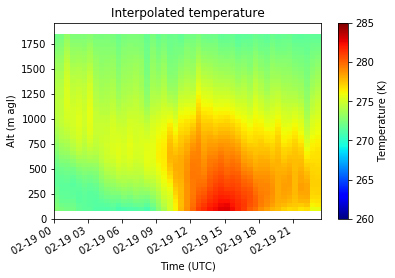

In [20]:
plt.figure()
plt.title("Interpolated temperature")
plt.pcolormesh(t_common,z_common,T_query.T,vmin=260,vmax=285,cmap='jet')
plt.colorbar(label="Temperature (K)")
plt.gcf().autofmt_xdate()
plt.xlabel("Time (UTC)")
plt.ylabel("Alt (m agl)")
plt.show(block=False)

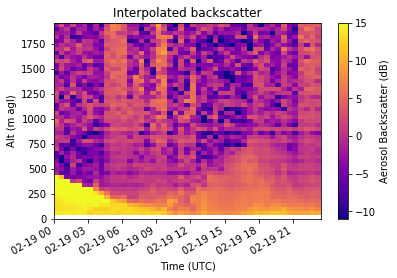

In [21]:
plt.figure()
plt.title("Interpolated backscatter")
with np.errstate(divide='ignore',invalid='ignore'):
	plt.pcolormesh(t_common,z_common,BT_query.T,vmin=-11,vmax=15,cmap='plasma')
plt.colorbar(label="Aerosol Backscatter (dB)")
plt.gcf().autofmt_xdate()
plt.xlabel("Time (UTC)")
plt.ylabel("Alt (m agl)")
plt.show(block=False)

The following blocks are gathered into the function `utils.estimateongrid`.
Some data can still be missing even after the interpolation
   * Radiometer : resolution coarsens with altitude => last gates missing
   * Ceilometer : high lowest range => first gates missing

In [22]:
trash,mask_T=prepdataset.deletelines(T_query,nan_max=T_query.shape[0]-1,return_mask=True,transpose=True,verbose=True)

trash,mask_BT=prepdataset.deletelines(BT_query,nan_max=BT_query.shape[0]-1,return_mask=True,transpose=True,verbose=True)

z_common=z_common[~np.logical_or(mask_T,mask_BT)]
T=T_query[:,~np.logical_or(mask_T,mask_BT)]
BT=BT_query[:,~np.logical_or(mask_T,mask_BT)]

Delete all lines with  47 missing values or more.
Too many NaN for obs  0 . Removed
Too many NaN for obs  1 . Removed
Too many NaN for obs  46 . Removed
Too many NaN for obs  47 . Removed
Too many NaN for obs  48 . Removed
Too many NaN for obs  49 . Removed
to_delete= [0, 1, 46, 47, 48, 49] . Total: 6
Delete all lines with  47 missing values or more.
Too many NaN for obs  0 . Removed
to_delete= [0] . Total: 1


In [23]:
# Add altitude in predictors (optional)
if 'Z' in predictors:
	X_raw = np.array([BT.ravel(),T.ravel(),np.tile(z_common,(T.shape[0],1)).ravel()]).T
else:
	X_raw = np.array([BT.ravel(),T.ravel()]).T

# Sanity checks
print("\nInvalid values after removing bad boundaries:")
with np.errstate(invalid='ignore'):
	print(" - X_raw - #NaN=",np.sum(np.isnan(X_raw)),"#Inf=",np.sum(np.isinf(X_raw)),"#Neg=",np.sum(X_raw<=0))
print("shape(X_raw)=",X_raw.shape)


Invalid values after removing bad boundaries:
 - X_raw - #NaN= 0 #Inf= 0 #Neg= 930
shape(X_raw)= (2112, 2)


Write dataset in netcdf file
------------------------------
The matrix X_raw is stored with the names of its columns and the grid on which is has been estimated.

In [24]:
datasetname='DATASET_PASSY2015_'+'-'.join(predictors)+'_'+interpMethod+'_dz'+str(dz_common)+'_dt'+str(dt_common)+'_zmax'+str(z_max)+'.nc'
if saveNetcdf:
    msg=prepdataset.write_dataset(outputDir+datasetname,X_raw,t_common,z_common)
    print(msg)
else:
    print("No netCDF saved. Set saveNetcdf=True if you want to save it")

No netCDF saved. Set saveNetcdf=True if you want to save it


How to choose the best interpolation?
-------------------------------------

In [25]:
z_target=z_common
t_target=t_common
z_known =z_mwr
t_known =t_mwr
V_known =temperature

In [26]:
st_known = utils.dtlist2slist(t_known)
st_target = utils.dtlist2slist(t_target)
X_known,Y_known=utils.grid_to_scatter(st_known,z_known,V_known)
X_target=utils.grid_to_scatter(st_target,z_target)

# NaN are removed
X_known = X_known[~np.isnan(Y_known),:]
Y_known = Y_known[~np.isnan(Y_known)]

In [27]:
regressors = []
reg_names = []
n_randoms = 30

#### ========= Estimation with 4-nearest neighbors
KNN4=KNeighborsRegressor(n_neighbors=4)
regressors.append(KNN)
reg_names.append("4NearestNeighbors")

#### ========= Estimation with 8-nearest neighbors
KNN8=KNeighborsRegressor(n_neighbors=8)
regressors.append(KNN8)
reg_names.append("8NearestNeighbors")

chronos = np.zeros((len(regressors)+2,n_randoms))
accuracies = np.zeros((len(regressors)+2,n_randoms))
for icl in range(len(regressors)):
    reg = regressors[icl]
    print("Testing ",str(reg).split('(')[0])
    for ird in range(n_randoms):
        X_train, X_test, y_train, y_test = train_test_split(X_known,Y_known,test_size=0.2, random_state=ird)
        t0=time.time()      #::::::
        reg.fit(X_train,y_train)
        accuracies[icl,ird]=reg.score(X_test,y_test)
        t1=time.time()      #::::::
        chronos[icl,ird]=t1-t0

#### ========= Estimation with 2D linear interpolation
reg_names.append('Linear2DInterp')
print("Testing Linear2DInterp")
for ird in range(n_randoms):
    X_train, X_test, y_train, y_test = train_test_split(X_known,Y_known,test_size=0.2, random_state=ird)
    y_pred = griddata(X_train,y_train,X_test,method='linear')
    # Some data can still be missing even after the interpolation
    #   * Radiometer : resolution coarsens with altitude => last gates missing
    #   * Ceilometer : high lowest range => first gates missing
    y_test = y_test[~np.isnan(y_pred)]
    y_pred = y_pred[~np.isnan(y_pred)]
    accuracies[-2,ird]=r2_score(y_test,y_pred)
    t1=time.time()      #::::::
    chronos[-2,ird]=t1-t0


#### ========= Estimation with 2D cubic interpolation
reg_names.append('Cubic2DInterp')
print("Testing Cubic2DInterp")
for ird in range(n_randoms):
    X_train, X_test, y_train, y_test = train_test_split(X_known,Y_known,test_size=0.2, random_state=ird)
    y_pred = griddata(X_train,y_train,X_test,method='linear')
    # Some data can still be missing even after the interpolation
    #   * Radiometer : resolution coarsens with altitude => last gates missing
    #   * Ceilometer : high lowest range => first gates missing
    y_test = y_test[~np.isnan(y_pred)]
    y_pred = y_pred[~np.isnan(y_pred)]
    accuracies[-1,ird]=r2_score(y_test,y_pred)
    t1=time.time()      #::::::
    chronos[-1,ird]=t1-t0

Testing  KNeighborsRegressor
Testing  KNeighborsRegressor
Testing Linear2DInterp
Testing Cubic2DInterp


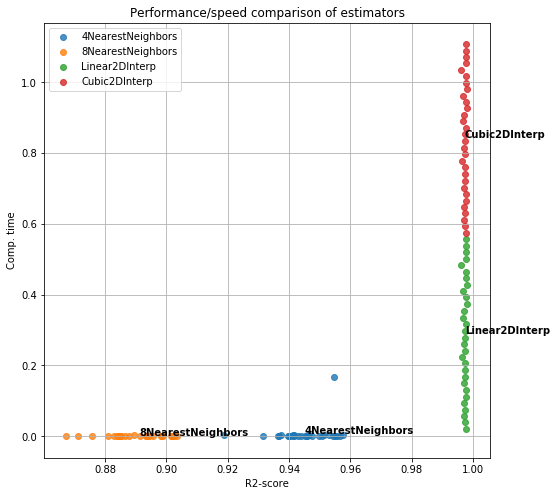

In [28]:
graphics.estimator_quality(accuracies,chronos,reg_names)

Conclusion
----------------
The previous figure shows us that the nearest neighbors methods are the fastest and their computing time do not depend on the number of neighbors. One can see that the quality of the interpolation decreases with the number of neighbors.
Cubic and linear 2-dimensional interpolation have similar performances, which is greater than nearest neighbors. Although, cubic interpolation has always higher computing time. Therefore, we chose the linear interpolation to prepare the data.